## Building Variational Auto-encoders using CNN in Pytorch

In [40]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
import os
from vae_model import VAE as model_architecture
from dataloader import CustomImageDataset
from matplotlib import pyplot as plt
import cv2

In [41]:
vae_cnn_model = model_architecture(mode="run")
# inp = torch.randn(4,3,128,128)
# output, mu, var, z = vae_cnn_model(inp)

In [42]:
root_path="./"

#### Model Parameters

In [43]:
LR = 1e-3
DIM = 128
EPOCH = 20
MODE = "train"
loss_fn = nn.MSELoss()
optimizer = optim.Adam(vae_cnn_model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

#### Data Transformations

In [44]:
transform = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    ToTensorV2(),
                ],
                )

In [46]:
training_data = CustomImageDataset(transform, mode="train")
validation_data = CustomImageDataset(transform, mode="valid")
test_data = CustomImageDataset(transform, mode="test")
train_dataloader = DataLoader(training_data, batch_size=5, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(validation_data, batch_size=5, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True, pin_memory=True)

In [47]:
epoch_tr_loss,epoch_vl_loss, epoch_ts_loss = [],[], []
epoch_tr_acc,epoch_vl_acc, epoch_ts_acc = [], [], []
test_acc = 0.0
test_batch_run = 0
test_losses = []
ep_to_load_model = 1
valid_loss_min = np.Inf
clip_value = 3


#### Combined Training Loss

In [48]:
def combined_loss(reconstruction_loss, mu, log_var):
    KL_Divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + KL_Divergence

### VAE Training

In [49]:
for ep in range(EPOCH):
    counter = 0
    valid_batch_run = 0
    train_batch_run = 0
    train_losses = []
    valid_losses = []
    vae_cnn_model.train() # switch to train mode
    with tqdm(train_dataloader, unit=" Train batch") as tepoch:
        tepoch.set_description(f"Train Epoch {ep+1}")
        for input_images, gt_paths in tepoch:
            train_batch_run += 1
            optimizer.zero_grad()
            predictions, means, log_vars, z = vae_cnn_model(input_images.float())
            reconstruction_loss = loss_fn(input=predictions, target=input_images.float())
            loss_value = combined_loss(reconstruction_loss, means, log_vars)
            train_losses.append(loss_value.item())
            loss_value.backward()
            nn.utils.clip_grad_norm_(vae_cnn_model.parameters(), clip_value)
            optimizer.step()
    vae_cnn_model.eval() # switch to eval mode
    with tqdm(validation_dataloader, unit=" Valid batch") as vepoch:
        vepoch.set_description(f"Valid Epoch {ep+1}")
        for input_images, gt_paths in vepoch:
            with torch.no_grad():
                predictions, means, log_vars, z = vae_cnn_model(input_images.float()) # get the mean and log_var
                for pred in predictions:
                    prediction = pred.numpy()
                    prediction = prediction*255
                    img = cv2.merge([prediction[0],prediction[1],prediction[2]])
                    cv2.imwrite("pred/pred_"+str(counter)+".jpg",img)
                    counter = counter + 1
            reconstruction_loss = loss_fn(input=predictions, target=input_images.float())
            loss_value = combined_loss(reconstruction_loss, means, log_vars)
            valid_losses.append(loss_value.item())
            valid_batch_run += 1
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(valid_losses)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    print(f'Epoch {ep+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    if epoch_val_loss <= valid_loss_min:
        os.system("rm ./models/vae*")
        print("removing stored weights of previous epoch")
        torch.save(vae_cnn_model.state_dict(), root_path+"models/vae_"+str(ep+1)+".pt")
        print("storing weights of current epoch")
        ep_to_load_model = ep+1
        print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    scheduler.step()
    


        
        
        
        


Valid Epoch 1: 100%|████████████████████| 5/5 [00:00<00:00, 13.10 Valid batch/s]


Epoch 1
train_loss : 0.1624910533428192 val_loss : 0.049762504547834395
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (inf --> 0.04976250).  Saving model ...


Valid Epoch 2: 100%|████████████████████| 5/5 [00:00<00:00, 16.67 Valid batch/s]


Epoch 2
train_loss : 0.07905282080173492 val_loss : 0.04655658528208732
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04976250 --> 0.04655659).  Saving model ...


Valid Epoch 3: 100%|████████████████████| 5/5 [00:00<00:00, 14.48 Valid batch/s]


Epoch 3
train_loss : 0.07377656996250152 val_loss : 0.046456503123044966
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04655659 --> 0.04645650).  Saving model ...


Valid Epoch 4: 100%|████████████████████| 5/5 [00:00<00:00, 16.78 Valid batch/s]


Epoch 4
train_loss : 0.07168251723051071 val_loss : 0.04530890882015228
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04645650 --> 0.04530891).  Saving model ...


Valid Epoch 5: 100%|████████████████████| 5/5 [00:00<00:00, 16.82 Valid batch/s]


Epoch 5
train_loss : 0.071559988707304 val_loss : 0.04173455387353897
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04530891 --> 0.04173455).  Saving model ...


Valid Epoch 6: 100%|████████████████████| 5/5 [00:00<00:00, 17.43 Valid batch/s]


Epoch 6
train_loss : 0.07053271159529687 val_loss : 0.04251292869448662


Valid Epoch 7: 100%|████████████████████| 5/5 [00:00<00:00, 16.79 Valid batch/s]


Epoch 7
train_loss : 0.07068326696753502 val_loss : 0.04231622964143753


Valid Epoch 8: 100%|████████████████████| 5/5 [00:00<00:00, 17.51 Valid batch/s]


Epoch 8
train_loss : 0.0708615668118 val_loss : 0.042572684586048126


Valid Epoch 9: 100%|████████████████████| 5/5 [00:00<00:00, 17.31 Valid batch/s]


Epoch 9
train_loss : 0.0709589622914791 val_loss : 0.04255019202828407


Valid Epoch 10: 100%|███████████████████| 5/5 [00:00<00:00, 17.30 Valid batch/s]


Epoch 10
train_loss : 0.07164054214954377 val_loss : 0.041573716700077055
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04173455 --> 0.04157372).  Saving model ...


Valid Epoch 11: 100%|███████████████████| 5/5 [00:00<00:00, 16.75 Valid batch/s]


Epoch 11
train_loss : 0.07143168151378632 val_loss : 0.04239385351538658


Valid Epoch 12: 100%|███████████████████| 5/5 [00:00<00:00, 16.63 Valid batch/s]


Epoch 12
train_loss : 0.0712753914296627 val_loss : 0.04346954822540283


Valid Epoch 13: 100%|███████████████████| 5/5 [00:00<00:00, 17.43 Valid batch/s]


Epoch 13
train_loss : 0.07014928013086319 val_loss : 0.04260668680071831


Valid Epoch 14: 100%|███████████████████| 5/5 [00:00<00:00, 16.15 Valid batch/s]


Epoch 14
train_loss : 0.07051839753985405 val_loss : 0.04123760014772415
removing stored weights of previous epoch
storing weights of current epoch
Validation loss decreased (0.04157372 --> 0.04123760).  Saving model ...


Valid Epoch 15: 100%|███████████████████| 5/5 [00:00<00:00, 16.85 Valid batch/s]


Epoch 15
train_loss : 0.07048089206218719 val_loss : 0.04252362325787544


Valid Epoch 16: 100%|███████████████████| 5/5 [00:00<00:00, 17.45 Valid batch/s]


Epoch 16
train_loss : 0.0714206263422966 val_loss : 0.041319701820611954


Valid Epoch 17: 100%|███████████████████| 5/5 [00:00<00:00, 17.59 Valid batch/s]


Epoch 17
train_loss : 0.07072900384664535 val_loss : 0.04186377078294754


Valid Epoch 18: 100%|███████████████████| 5/5 [00:00<00:00, 17.54 Valid batch/s]


Epoch 18
train_loss : 0.07050295472145081 val_loss : 0.04251471236348152


Valid Epoch 19: 100%|███████████████████| 5/5 [00:00<00:00, 13.35 Valid batch/s]


Epoch 19
train_loss : 0.07042125090956688 val_loss : 0.042543564736843106


Valid Epoch 20: 100%|███████████████████| 5/5 [00:00<00:00, 17.24 Valid batch/s]

Epoch 20
train_loss : 0.07115133479237556 val_loss : 0.04309203624725342


#### Generate Results on Test set

In [50]:
ep_to_load_model=14
os.system("rm ./pred/*")

0

In [51]:
vae_cnn_model.load_state_dict(torch.load(root_path+"models/vae_"+str(ep_to_load_model)+".pt"))
vae_cnn_model.eval()
with tqdm(test_dataloader, unit=" Test batch") as test_epoch:
    counter = 0
    test_epoch.set_description(f"Test Epoch {ep_to_load_model}")
    template_input = np.ones((50,128,3))*255
    template_input = template_input.astype(np.uint8)
    template_pred = np.ones((50,128,3))*255
    template_pred = template_pred.astype(np.uint8)
    template_gen = np.ones((50,128,3))*255
    template_gen = template_gen.astype(np.uint8)
    cv2.putText(template_input, "Input", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA)
    cv2.putText(template_pred, "Prediction", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1, cv2.LINE_AA)
    cv2.putText(template_gen, "Generation", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 1, cv2.LINE_AA)
    for input_images, gt_paths in test_epoch:
        with torch.no_grad():
            batch,_,_,_= input_images.shape
            outputs, means, log_vars, z = vae_cnn_model(input_images.float())
            # pass mean and log_var values to generate new results.
            new_predictions = vae_cnn_model(x=None, mean=means.float()*0.80, log_var=log_vars.float()*0.98, mode="generate") 
            for pred_idx in range(len(new_predictions)):
                inp_image = input_images[pred_idx]
                inp_image = inp_image.numpy()*255
                inp_image = cv2.merge([inp_image[0],inp_image[1],inp_image[2]])
                inp_image = inp_image.astype(np.uint8)
                pred = outputs[pred_idx]
                prediction = pred.numpy()*255
                gen_pred = new_predictions[pred_idx]
                gen_prediction = gen_pred.numpy()
                gen_prediction = gen_prediction*255
                pred_img = cv2.merge([prediction[0],prediction[1],prediction[2]])
                pred_img = pred_img.astype(np.uint8)
                inp_image = cv2.vconcat([template_input, inp_image])
                pred_img = cv2.vconcat([template_pred, pred_img])
                gen_img = cv2.merge([gen_prediction[0],gen_prediction[1],gen_prediction[2]])
                gen_img = gen_img.astype(np.uint8)
                gen_img = cv2.vconcat([template_gen, gen_img])
                img = cv2.hconcat([inp_image, pred_img, gen_img])
                cv2.imwrite("pred/pred_"+str(counter)+".jpg",img)
                counter = counter + 1
        reconstruction_loss = loss_fn(input=new_predictions, target=input_images.float())
        loss_value = combined_loss(reconstruction_loss, means, log_vars)
        test_losses.append(loss_value.item())
        test_batch_run += 1
    epoch_test_loss = np.mean(test_losses)
    epoch_ts_loss.append(epoch_test_loss)
    print(f'test_loss : {epoch_test_loss}')

Test Epoch 14: 100%|█████████████████████| 2/2 [00:00<00:00,  9.42 Test batch/s]

test_loss : 0.07318374514579773


#### Visualise results on Test set

In [52]:
import glob
filename_list = glob.glob("pred/*.jpg")

In [67]:
read_index= 2

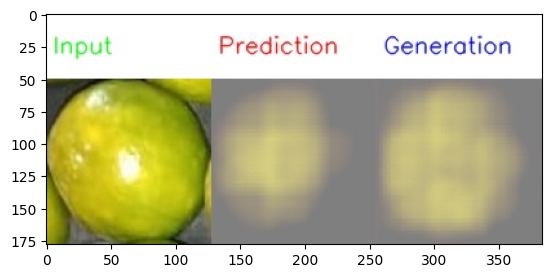

In [68]:
read_image= cv2.imread(filename_list[read_index])
img=read_image[:,:,::-1]
plt.imshow(img)